# Creating the core text dataset

## Dependencies

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os

## Investigating the .csv

In [38]:
csv_file_path = os.path.join(os.getcwd(), '..', 'resource', 'edos_labelled_individual_annotations.csv')
df_nlp = pd.read_csv(csv_file_path)
df_nlp

train = df_nlp.loc[df_nlp["split"] == "train"]
train

test = df_nlp.loc[df_nlp["split"] == "test"]
test

,rewire_id,text,annotator,label_sexist,label_category,label_vector,split
27,sexism2022_english-10004,Happy Birthday to your daughter GTR😊,8,not sexist,none,none,test
28,sexism2022_english-10004,Happy Birthday to your daughter GTR😊,9,not sexist,none,none,test
29,sexism2022_english-10004,Happy Birthday to your daughter GTR😊,16,not sexist,none,none,test
30,sexism2022_english-10005,NEGRO Baltimore mayor and NEGRO police commiss...,9,not sexist,none,none,test
31,sexism2022_english-10005,NEGRO Baltimore mayor and NEGRO police commiss...,17,not sexist,none,none,test
...,...,...,...,...,...,...,...
59992,sexism2022_english-9997,"You can stop right there asshole, she is a mar...",1,not sexist,none,none,test
59993,sexism2022_english-9997,"You can stop right there asshole, she is a mar...",16,not sexist,none,none,test
59994,sexism2022_english-9998,"Since 1973, America has sanctioned the murder ...",8,sexist,4. prejudiced discussions,4.2 supporting systemic discrimination against...,test
59995,sexism2022_english-9998,"Since 1973, America has sanctioned the murder ...",2,sexist,4. prejudiced discussions,4.2 supporting systemic discrimination against...,test


The dataset consists of 60,000 entries across 7 columns, detailing instances of text labeled for sexism. Each row represents a unique annotator’s evaluation of a specific text and each text is evaluated three times by different annotators. The columns include identifiers (rewire_id, annotator), the text itself, and labels (label_sexist, label_category, label_vector, and split). We have columns to distinguish each annotator’s perspective on whether a text is sexist, categorize the type of sexism, and designate the dataset split (train, test, dev). For our task we only going to need the label_sexist label for binary classification.

In [39]:
df_nlp.info()
n_all = len(df_nlp)
n_train = len(train)
n_test = len(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rewire_id       60000 non-null  object
 1   text            60000 non-null  object
 2   annotator       60000 non-null  int64 
 3   label_sexist    60000 non-null  object
 4   label_category  60000 non-null  object
 5   label_vector    60000 non-null  object
 6   split           60000 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.2+ MB


In [40]:
traintest = df_nlp['split'].value_counts()
print(traintest)

split
train    42000
test     12000
dev       6000
Name: count, dtype: int64


The dataset is divided into three subsets: training (42,000 entries), testing (12,000 entries), and development (6,000 entries). This distribution ensures that there is enough data for model training and validation, with a smaller portion reserved for final testing.

In [41]:
#how is the sexist / not sexist rate
sexistornot_all = df_nlp['label_sexist'].value_counts()
print(sexistornot_all) #this rate should be represented in the train and test dataset each
print(f"\nThe rate of the sexist texts in the whole dataset: {sexistornot_all['sexist'] / n_all *100}%\n")

sexistornot_train = train['label_sexist'].value_counts()
print(sexistornot_train) 
print(f"\nThe rate of the sexist texts in the train dataset: {sexistornot_train['sexist'] / n_train *100}%\n")

sexistornot_test = test['label_sexist'].value_counts()
print(sexistornot_test) 
print(f"\nThe rate of the sexist texts in the test dataset: {sexistornot_test['sexist'] / n_test *100}%\n")

label_sexist
not sexist    44670
sexist        15330
Name: count, dtype: int64

The rate of the sexist texts in the whole dataset: 25.55%

label_sexist
not sexist    31271
sexist        10729
Name: count, dtype: int64

The rate of the sexist texts in the train dataset: 25.545238095238094%

label_sexist
not sexist    8885
sexist        3115
Name: count, dtype: int64

The rate of the sexist texts in the test dataset: 25.958333333333332%



Around 25.5% of the data has been labeled as sexist. This ratio is consistent across the train and test splits, indicating a balanced approach in labeling within each subset. Such balance is critical for training and evaluating a model that can accurately detect sexist language.

In [42]:
#any missing values in the text column?
no_text_count = df_nlp['text'].isnull().sum()
print(f"Number of empty rows in text column: {no_text_count}")

#missing values anywhere else
print("\nMissing values in each column:")
print(df_nlp.isnull().sum())

Number of empty rows in text column: 0

Missing values in each column:
rewire_id         0
text              0
annotator         0
label_sexist      0
label_category    0
label_vector      0
split             0
dtype: int64


There are no missing values in the text column or any other columns. This ensures completeness in the data, allowing us to proceed without imputing or dropping entries due to missing values.

In [43]:
#is there a text that has not been evaluated three times?
rewire_counts = df_nlp['rewire_id'].value_counts()
print("Texts with counts not equal to 3:")
print(rewire_counts[rewire_counts != 3]) #no

Texts with counts not equal to 3:
Series([], Name: count, dtype: int64)


Each rewire_id appears exactly three times, confirming that each text has been reviewed by three different annotators. This redundancy ensures a more robust and balanced assessment, reducing the potential for subjective bias from a single annotator.

In [44]:
#annotator ID range
print("Annotator ID range:")
print(f"Min: {df_nlp['annotator'].min()}, Max: {df_nlp['annotator'].max()}")

#any not expected values?
unexpected_annotators = df_nlp[(df_nlp['annotator'] < 1) | (df_nlp['annotator'] > 100)]
print("\nUnexpected annotator IDs:")
print(unexpected_annotators['annotator'].unique())

#how many inputs from each annotator?
annotator_counts = df_nlp['annotator'].value_counts()
print("\nAnnotator IDs count:")
print(annotator_counts) #might be biased because number 13 evaluated much more texts than number 18 for example

Annotator ID range:
Min: 0, Max: 18

Unexpected annotator IDs:
[0]

Annotator IDs count:
annotator
13    4813
8     4392
2     4372
4     4348
3     4336
9     4328
6     4325
1     4085
14    4017
15    3979
5     3592
10    3449
17    3382
16    3332
11     650
12     650
0      650
7      650
18     650
Name: count, dtype: int64


The annotator activity shows significant variation, with some annotators having evaluated many more texts than others. For instance, annotator 13 evaluated 4,813 texts, while some annotators only evaluated 650. This could introduce bias if certain annotators have subjective tendencies, as more frequent annotators contribute more heavily to the overall dataset labeling.

In [45]:
#duplicate rows?
duplicate_rows = df_nlp[df_nlp.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows)}")

Number of duplicate rows: 0


No duplicate rows were found, which means each entry is unique in terms of rewire_id, annotator, and text. This contributes to the reliability of the dataset.

In [46]:
#rows where 'text' contains any text between square brackets
bracketed_texts = df_nlp['text'].str.extractall(r"(\[.*?\])")[0]

#unique bracketed texts
unique_bracketed_texts = bracketed_texts.drop_duplicates()
print("Unique bracketed texts found in the dataset:")
print(unique_bracketed_texts)

#occurrences of each unique bracketed text
bracketed_text_counts = bracketed_texts.value_counts()

#counts
print("Counts of each unique bracketed text:")
print(bracketed_text_counts)

#list of unique bracketed texts
unique_bracketed_texts = bracketed_text_counts.index.tolist()
print("\nList of unique bracketed texts:")
print(unique_bracketed_texts)

Unique bracketed texts found in the dataset:
       match
0      0                 [USER]
30     0                  [URL]
870    0                 [link]
1065   0                 [Link]
1227   0                 [[URL]
                     ...       
56232  0               [/cynic]
56886  0        [So here it is]
57702  0           [NSFL photo]
58731  0            [This one?]
59571  4               [faggot]
Name: 0, Length: 94, dtype: object
Counts of each unique bracketed text:
0
[URL]                                                                                                                                7395
[USER]                                                                                                                               4065
[[URL]                                                                                                                                 36
[this]                                                                                               

Several texts contain bracketed placeholders (e.g., [URL], [USER]) representing masked information, such as links or usernames, which may obscure certain context. This information should be handled carefully, as it could affect how the text is interpreted by both human annotators and NLP models. This means we have to decide for each one of the values whether to stay in the dataset or to be deleted. 
We came to the agreement that every phrase that has no meaning or influence should be deleted from the dataset, such as [USER], [Link], [URL], [...], [twitter], [tumblr], [CLICK HERE], and so on.

## Preprocessing step

In [52]:
terms_to_remove = [
    r'\[USER\]', r'\[URL\]', r'\[deleted\]', r'\[\[URL\]', r'\[_\]', r'\[Link\]', r'\[link\]', 
    r'\[twitter\]', r'\[tumblr\]', r'\[CLICK HERE\]', r'\[…\]', r'\[e\]', r'\[\[URL\]', r'\[K\]'
]

# Join all terms into a single regex pattern with `|` (OR), making it case-insensitive
pattern = '|'.join(terms_to_remove)

# Replace matches with an empty string
df_nlp['text'] = df_nlp['text'].str.replace(pattern, '', regex=True, case=False) #here we should create a list for the values to be deleted
df_nlp #final dataset

,rewire_id,text,annotator,label_sexist,label_category,label_vector,split
0,sexism2022_english-0,I wonder what keeps that witch looking quite ...,17,sexist,2. derogation,2.2 aggressive and emotive attacks,train
1,sexism2022_english-0,I wonder what keeps that witch looking quite ...,2,sexist,2. derogation,2.2 aggressive and emotive attacks,train
2,sexism2022_english-0,I wonder what keeps that witch looking quite ...,6,not sexist,none,none,train
3,sexism2022_english-1,"What do you guys think about female ""incels""? ...",17,not sexist,none,none,train
4,sexism2022_english-1,"What do you guys think about female ""incels""? ...",15,not sexist,none,none,train
...,...,...,...,...,...,...,...
59995,sexism2022_english-9998,"Since 1973, America has sanctioned the murder ...",2,sexist,4. prejudiced discussions,4.2 supporting systemic discrimination against...,test
59996,sexism2022_english-9998,"Since 1973, America has sanctioned the murder ...",16,not sexist,none,none,test
59997,sexism2022_english-9999,Laura Bates Lol she looks like she'd suck the ...,2,sexist,2. derogation,2.2 aggressive and emotive attacks,train
59998,sexism2022_english-9999,Laura Bates Lol she looks like she'd suck the ...,16,not sexist,none,none,train


After we deleted the words that have no meaning in the text, we are done with the necessary preprocessing steps. As the output, we now have our core text datasets preprocessed and stored in a standard format: the final dataset is saved as edos_labelled_clean in a .csv format in the *resources* folder.

## Saving the clean dataframe

In [53]:
savepath = os.path.join(os.getcwd(), '..', 'resource', 'edos_labelled_clean.csv')
df_nlp.to_csv(savepath)

# Appendix

## Try to see the balance in the sexist and not sexist labels

In [49]:
whatkind = df_nlp['label_vector'].value_counts()
print(whatkind)

label_vector
none                                                               44670
2.1 descriptive attacks                                             3665
2.2 aggressive and emotive attacks                                  2732
3.1 casual use of gendered slurs, profanities, and insults          2671
3.2 immutable gender differences and gender stereotypes             1506
2.3 dehumanising attacks & overt sexual objectification             1161
4.2 supporting systemic discrimination against women as a group     1094
1.2 incitement and encouragement of harm                             966
4.1 supporting mistreatment of individual women                      515
3.4 condescending explanations or unwelcome advice                   431
3.3 backhanded gendered compliments                                  301
1.1 threats of harm                                                  288
Name: count, dtype: int64


## Distribution in Label Sexist Category and Label Category

/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_11760/3319808314.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_nlp, x='label_sexist', palette="viridis", ax=axes[0])
/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_11760/3319808314.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_nlp, x='label_category', palette="viridis", order=df_nlp['label_category'].value_counts().index, ax=axes[1])


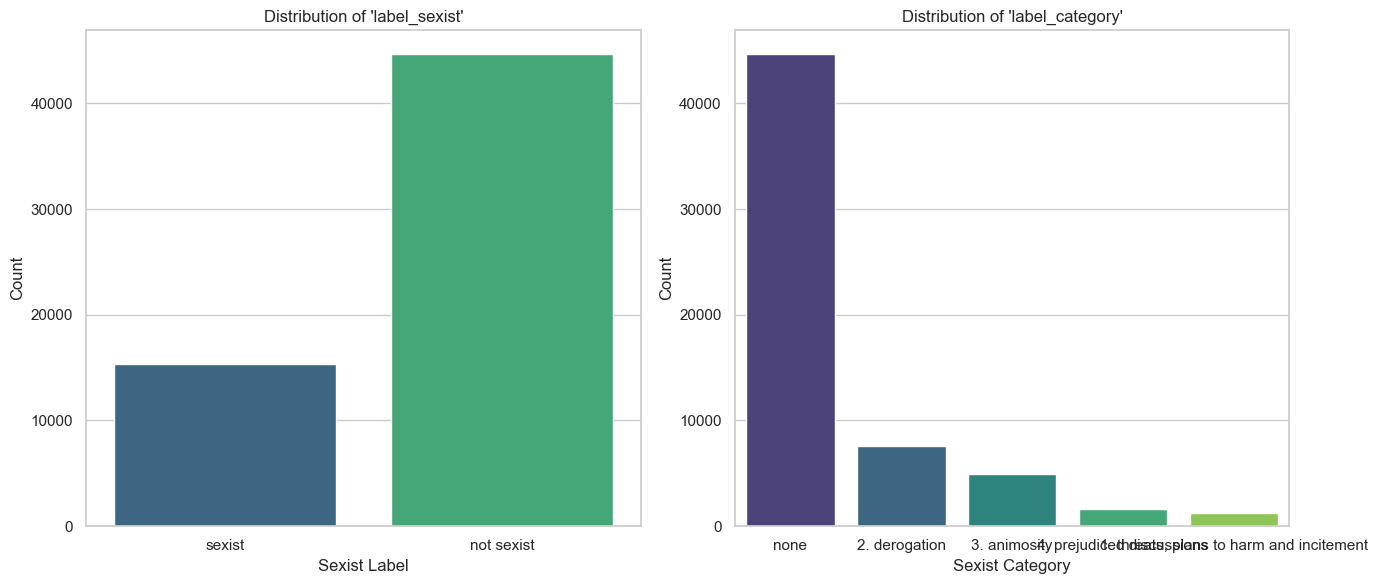

In [30]:

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.countplot(data=df_nlp, x='label_sexist', palette="viridis", ax=axes[0])
axes[0].set_title("Distribution of 'label_sexist'")
axes[0].set_xlabel("Sexist Label")
axes[0].set_ylabel("Count")


sns.countplot(data=df_nlp, x='label_category', palette="viridis", order=df_nlp['label_category'].value_counts().index, ax=axes[1])
axes[1].set_title("Distribution of 'label_category'")
axes[1].set_xlabel("Sexist Category")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

## Print rows where label category something but label vector none

In [31]:
notmatching = df_nlp[(df_nlp['label_sexist']=="sexist")&(df_nlp['label_category'] != "none")&(df_nlp['label_vector']=="none")]
print(notmatching)


Empty DataFrame
Columns: [rewire_id, text, annotator, label_sexist, label_category, label_vector, split]
Index: []


In [32]:
notmatching = df_nlp[(df_nlp['label_sexist']=="sexist")&(df_nlp['label_vector'] != "none")&(df_nlp['label_category']=="none")]
print(notmatching)


Empty DataFrame
Columns: [rewire_id, text, annotator, label_sexist, label_category, label_vector, split]
Index: []


# Appendix

In [51]:
#Creating a list of what I think are the sexist words in some of the lines which were labeled sexist

badwords = ["bitch", "slag", "slut"]

def contains_badword(dfcolumn, list):
    
    found_words = [list for list in list if re.search(r'\b' + re.escape(list) + r'\b', dfcolumn.lower())]

    return found_words

df_app = df_nlp.copy()
df_app['bad_words_found'] = df_app['text'].apply(lambda x: contains_badword(x, badwords))

# Add a column for the count of bad words found
df_app['bad_word_count'] = df_app['bad_words_found'].apply(len)

# Filter rows where bad words are found
bad_word_rows = df_app[df_app['bad_word_count'] > 0]

print(bad_word_rows[['bad_words_found', 'bad_word_count']])


      bad_words_found  bad_word_count
18      [bitch, slag]               2
19      [bitch, slag]               2
20      [bitch, slag]               2
42             [slut]               1
43             [slut]               1
...               ...             ...
59869          [slut]               1
59870          [slut]               1
59925         [bitch]               1
59926         [bitch]               1
59927         [bitch]               1

[2112 rows x 2 columns]


## Loading the compiled list of bad words

In [34]:
def load_bad_words(file_path):
    with open(file_path, 'r') as file:
        # Read lines and strip newline characters
        bad_words = [line.strip().lower() for line in file.readlines()]
    return bad_words

#Reading the derogatory words into list
badwords_file_path = os.path.join(os.getcwd(), '..', 'resource', 'compiled_bad_words.txt')
badwordstxt = load_bad_words(badwords_file_path)
print(badwordstxt)


['cockknocker', 'n1gger', 'f ing', 'fukker', 'nympho', 'fcuking', 'gook', 'freex', 'arschloch', 'fistfucked', 'chinc', 'raunch', 'fellatio', 'splooge', 'nutsack', 'lmfao', 'wigger', 'bastard', 'asses', 'fistfuckings', 'blue waffle', 'beeyotch', 'pissin', 'dominatrix', 'fisting', 'vullva', 'paki', 'cyberfucker', 'chuj', 'penuus', 'masturbate', 'b00b*', 'fuks', 'sucked', 'fuckingshitmotherfucker', 'feces', 'panty', 'coital', 'wh00r. whore', 'condom', 'hells', 'foreskin', 'wanker', 'hoer', 'sh1tz', 'shittings', 'wtf', 'recktum', 'dick*', 'pr0n', 'pasty', 'spik', 'phukked', 'assfuck', 'xxx', 'nigger*', 'ugly', 's_h_i_t', 'mamhoon', 'pornos', 'masterbates', 'mothafucks', 'mother fukkah', 'chink', 'pussy palace', 'azazel', 'fistfucking', 'ass-fucker', 'shag', 'chincs', 'duche', 'orgies', 'vag1na', 'molest', 'bollock', 'a-hole', 'seduce', 'cock*', 'dog-fucker', 'shitz', 'mother fucker', 'penial', 'biatch', 'junky', 'orifice', '5hit', 'kunilingus', 'cuntbag', 'hump', 'butt fuck', 'titwank', 's

## Searching rows for bad words

In [35]:
badword_pattern = r'\b(' + '|'.join(map(re.escape, badwordstxt)) + r')\b'

# Use `str.findall()` to find all occurrences of bad words in each row, then count them
df_app = df_nlp.copy()
df_app['bad_words_found'] = df_app['text'].str.findall(badword_pattern, flags=re.IGNORECASE)

df_app['bad_word_count'] = df_app['bad_words_found'].str.len()

bad_word_rows = df_app[df_app['bad_word_count'] > 0]

print(bad_word_rows[['bad_words_found', 'bad_word_count']])

         bad_words_found  bad_word_count
3                 [shit]               1
4                 [shit]               1
5                 [shit]               1
6               [vagina]               1
7               [vagina]               1
...                  ...             ...
59995           [murder]               1
59996           [murder]               1
59997  [suck, dick, god]               3
59998  [suck, dick, god]               3
59999  [suck, dick, god]               3

[27507 rows x 2 columns]


In [50]:
savepath = os.path.join(os.getcwd(), '..', 'resource', 'badwordrows.csv')
bad_word_rows.to_csv(savepath)